# LLM example Usecase: Climate Indicator Classification

### Install Packages

In [3]:
%pip install pandas accelerate transformers torch scikit-learn marvin openpyxl

  Obtaining dependency information for openpyxl from https://files.pythonhosted.org/packages/6a/94/a59521de836ef0da54aaf50da6c4da8fb4072fb3053fa71f052fd9399e7a/openpyxl-3.1.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for et-xmlfile from https://files.pythonhosted.org/packages/96/c2/3dd434b0108730014f1b96fd286040dc3bcb70066346f7e01ec2ac95865f/et_xmlfile-1.1.0-py3-none-any.whl.metadata
Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Loading the data

In [6]:
import pandas as pd

excel_file_path = "../data/ej_dataset.xlsx" # you can get this file from: https://docs.google.com/spreadsheets/d/1Fk_WKMAYUz3Yl49QspZDGXrEMJq9pmAF/edit?usp=sharing&ouid=107577045329506013851&rtpof=true&sd=true
df = pd.read_excel(excel_file_path, engine="openpyxl")

df = df.dropna()
df.sample(frac=1).reset_index(drop=True)

,Indicators,Description
0,Health & Air Quality,The Global 3-Year Running Mean Ground-Level Ni...
1,Food Availability,The NASA Making Earth System Data Records for ...
2,Extreme Heat,"Within the viewer, select the parameter or fie..."
3,Human Dimensions,"The INFORM Global Risk Index 2019 Mid Year, v0..."
4,Health & Air Quality,The Global 3-Year Running Mean Ground-Level Ni...
...,...,...
247,Health & Air Quality,The Daily and Annual PM2.5 Concentrations for ...
248,Human Dimensions,The Global Gridded Geographically Based Econom...
249,Disasters,This dataset provides maps at 30-m resolution ...
250,Health & Air Quality,Measurements of Pollution in the Troposphere (...


## Load the Encoder Model using Huggingface package

### Tokenizer Initialization:
Initializes the tokenizer using the specified model_name. The tokenizer is responsible for converting text input into a format that is understandable by the model, including tasks like splitting the text into tokens, converting tokens to their corresponding IDs in the model's vocabulary, and applying any model-specific preprocessing steps.

### Model Initialization:
Loads a pre-trained model for sequence classification from the given model_name, specifying that the model should be configured to handle 8 distinct labels. This model is designed for tasks like sentiment analysis or topic classification, where the goal is to categorize text sequences into one of several categories.

### Data Collator Setup:
Creates a data collator that automatically pads tokenized inputs to the longest sequence in a batch, ensuring consistent input sizes for model training or evaluation. The DataCollatorWithPadding uses the tokenizer's padding token to fill any shorter sequences up to the length of the longest sequence in the batch.

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

# Load your domain-specific encoder model (replace 'model_name' with your model's name)
model_name = 'distilbert-base-uncased'
# model_name = 'nasa-impact/nasa-smd-ibm-v0.1'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=8)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


/Users/mramasub/work/workshop-usecases-llm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Encode the data and Labels into ML-ready format

### Tokenization and Model Preparation
This following code block initializes a tokenizer and a `sequence classification` model from pre-trained model initialized in the previous step. The tokenizer is used to convert text into a format that the model can understand, while the model is set up for sequence classification tasks with a specified number of labels (num_labels=8). Additionally, a `data collator` is initialized to dynamically pad the tokenized inputs to the maximum length in a batch, ensuring consistent input sizes for model training.

### Encoding Labels and Preparing Datasets
The second code block imports necessary libraries and defines a custom dataset class, CustomDataset, for handling the encoding of text and labels. It utilizes LabelEncoder from scikit-learn to convert text labels into numerical form. The dataset is then split into training and testing sets, with text descriptions tokenized and attention masks generated using the previously initialized tokenizer. The custom dataset class takes these encodings and creates PyTorch compatible datasets for both training and testing, suitable for loading into a model for training or evaluation.

In [8]:
## encode labels
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['Indicators'])
# print the label mapping
for index, item in enumerate(label_encoder.classes_):
    print(item, '->', index)

data = df
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['labels'])
train_encodings = tokenizer(list(train_data['Description']), return_tensors='pt', padding=True, truncation=True, max_length=512, return_attention_mask=True)
test_encodings = tokenizer(list(test_data['Description']), return_tensors='pt', padding=True, truncation=True, max_length=512, return_attention_mask=True)
train_dataset = CustomDataset(train_encodings, torch.tensor(train_data['labels'].tolist()))
test_dataset = CustomDataset(test_encodings, torch.tensor(test_data['labels'].tolist()))


Climate Change -> 0
Disasters -> 1
Extreme Heat -> 2
Food Availability -> 3
Health & Air Quality -> 4
Human Dimensions -> 5
Urban Flooding -> 6
Water Availability -> 7


## Create training and evaluation arguments for the Huggingface Trainer

### Training Configuration and Initialization
This code block sets up the training arguments for fine-tuning a sequence classification model using the Hugging Face Transformers Trainer API. It configures various parameters such as batch size, evaluation strategy, output directory, number of training epochs, logging directory, optimizer type (adamw_torch), and learning rate.
    a Trainer object is instantiated with the model, training arguments, training and evaluation datasets, data collator, and a custom function to compute metrics using the classification_report from scikit-learn. The Trainer is responsible for managing the training and evaluation processes, including batching, optimization, and logging.

Finally, the trainer is used to fine-tune the model on the training dataset and evaluate its performance on the testing dataset. The resulting metrics, including precision, recall, and F1 score for each class, are printed.

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    output_dir="./output",
    num_train_epochs=1,
    save_steps=50,
    save_total_limit=2,
    remove_unused_columns=True,
    logging_dir="./logs",
    optim="adamw_torch",
    learning_rate=5e-5,
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=lambda p: classification_report(p.label_ids, p.predictions.argmax(-1), output_dict=True),
)


trainer.train()

results = trainer.evaluate()

# Print classification report
print("Classification Report:")
print(results)

## Evaluation on the test set

In [ ]:
results

{'eval_loss': 0.23960325121879578,
 'eval_0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4},
 'eval_1': {'precision': 1.0,
  'recall': 0.3333333333333333,
  'f1-score': 0.5,
  'support': 3},
 'eval_2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6},
 'eval_3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3},
 'eval_4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13},
 'eval_5': {'precision': 0.8947368421052632,
  'recall': 1.0,
  'f1-score': 0.9444444444444444,
  'support': 17},
 'eval_6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4},
 'eval_7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1},
 'eval_accuracy': 0.9607843137254902,
 'eval_macro avg': {'precision': 0.986842105263158,
  'recall': 0.9166666666666666,
  'f1-score': 0.9305555555555556,
  'support': 51},
 'eval_weighted avg': {'precision': 0.9649122807017544,
  'recall': 0.9607843137254902,
  'f1-score': 0.952069716775

## Saving the model for later use

In [10]:
model.save_pretrained('ej_classifier')  # Replace 'your_model_directory' with your desired directory
tokenizer.save_pretrained('ej_tokenizer')  # Save the tokenizer as well

# load the model
# from transformers import AutoModelForSequenceClassification, AutoTokenizer
# model = AutoModelForSequenceClassification.from_pretrained('ej_classifier')
# tokenizer = AutoTokenizer.from_pretrained('ej_tokenizer')

('ej_tokenizer/tokenizer_config.json',
 'ej_tokenizer/special_tokens_map.json',
 'ej_tokenizer/vocab.txt',
 'ej_tokenizer/added_tokens.json',
 'ej_tokenizer/tokenizer.json')

## Predicting using the saved model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import torch
import pandas as pd

# Load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('ej_classifier')  # Load from the directory where you saved it
tokenizer = AutoTokenizer.from_pretrained('ej_tokenizer')

# Get predictions
with torch.no_grad():
    outputs = model(**test_encodings)

# Extract predicted class labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

predicted_class_labels = label_encoder.inverse_transform(predicted_labels.numpy())

# print the text, true and predicted labels
for i in range(len(test_data)):
    print(test_data['Description'].iloc[i])
    print('True:', test_data['Indicators'].iloc[i])
    print('Predicted:', label_encoder.classes_[predicted_labels[i]])
    print('')

This monthly climatology data set contains a series of land surface parameters simulated from the Noah land-surface model (LSM) for Phase 2 of the North American Land Data Assimilation System (NLDAS-2).  The data are in 1/8th degree grid spacing. The temporal resolution is monthly, ranging from January to December. The NLDAS-2 monthly climatology data are the monthly data averaged over the thirty years (1980 - 2009) of the NLDAS-2 monthly data. The file format is WMO GRIB-1.
True: Extreme Heat
Predicted: Extreme Heat

The NASA Making Earth System Data Records for Use in Research Environments (MEaSUREs) (https://earthdata.nasa.gov/community/community-data-system-programs/measures-projects) Global Food Security-support Analysis Data (GFSAD) data product provides cropland extent data over Southeast and Northeast Asia for nominal year 2015 at 30 meter resolution (GFSAD30SEACE). The monitoring of global cropland extent is critical for policymaking and provides important baseline data that a

# using OpenAI GPT 3.5 to do the same task (using Marvin AI)

## Marvin AI 
Marvin AI is a lightweight AI toolkit designed for building python interfaces using natural language, powered by LLMs. 
Marvin can be used for classification, entity extraction and other generation tasks using python type hints and docstrings.

In [ ]:
from typing import Literal, List
from pprint import pprint
import marvin
import pandas as pd
from tqdm import tqdm
import dotenv

dotenv.load_dotenv()
pd.set_option('display.max_colwidth', None)

# initialize Marvin
marvin.settings.openai.chat.completions.model = 'gpt-3.5-turbo'
marvin.settings.openai.api_key  = os.getenv('OPENAI_API_KEY')
labels = tuple(label_encoder.classes_)


# Define a function to classify the descriptions
@marvin.fn
def data_description_classifier(descriptions: str) ->  Literal[labels]:
    """
    classify `descriptions` into one or more of the labels in the Literal
    """

# Define a function to classify the descriptions, by providing a few examples
@marvin.fn
def data_description_classifier_few_shot(descriptions: str) ->  Literal[labels]:
    """
    classify `descriptions` into one or more of the labels in the Literal
    examples:
    The Flood Dashboard brings together multiple NASA soil moisture and flood products with products from the National Weather Service and USGS to give a more complete picture of potential flooding in the United States. Includes data from Soil Moisture Map, USGS Stream Gauges, and MODIS Flood Maps. -> Urban Flooding
    The Global Gridded Relative Deprivation Index (GRDI), Version 1 (GRDIv1) data set characterizes the relative levels of multidimensional deprivation and poverty in each 30 arc-second (~1 km) pixel, where a value of 100 represents the highest level of deprivation and a value of 0 the lowest. -> Human Dimensions
    The OMPS-NPP L2 NM Aerosol Index swath orbital product provides aerosol index values from the Ozone Mapping and Profiling Suite (OMPS) Nadir-Mapper (NM) instrument on the Suomi-NPP satellite. -> Health & Air Quality
    Landsat surface temperature measures the Earth’s surface temperature in Kelvin -> Extreme Heat
    This dataset contains the Global Mean Sea Level (GMSL) trend generated from the Integrated Multi-Mission Ocean Altimeter Data for Climate Research Version 5.1 -> Climate Change
    """


def accuracy(predicted_label: str, true_label: str) -> float:
    """
    calculate the accuracy of the predicted label
    """
    return 1 if predicted_label == true_label else 0



In [ ]:
# create empty dataframe
df_result = pd.DataFrame(columns=['description', 'predicted_labels', 'true_labels', 'accuracy'])
num_records = len(df)
for i, data in tqdm(enumerate(df.to_dict(orient='records'))):
    try:
        predicted_category = data_description_classifier(
            data['Description'],
        )
    except Exception as e:
        print(e)
        predicted_category = None
    df_result.loc[i] = [data['Description'], predicted_category, data['Indicators'], accuracy(predicted_category, data['Indicators'])]
    if i > 0.2*num_records:
        break

average_accuracy = df_result['accuracy'].mean()
print(f"Average Accuracy with OpenAI GPT 3.5: {average_accuracy:.2f}")

51it [00:53,  1.06s/it]

Average Accuracy with OpenAI GPT 3.5: 0.54


## Few Shot Learning with GPT-3.5

In [ ]:
df_result = pd.DataFrame(columns=['description', 'predicted_labels', 'true_labels', 'accuracy'])
num_records = len(df)
for i, data in tqdm(enumerate(df.to_dict(orient='records'))):
    try:
        predicted_category = data_description_classifier_few_shot(
            data['Description'],
        )
    except Exception as e:
        # print(e)
        predicted_category = None
    df_result.loc[i] = [data['Description'], predicted_category, data['Indicators'], accuracy(predicted_category, data['Indicators'])]
    if i > 0.2*num_records:
        break

average_accuracy_few_shot = df_result['accuracy'].mean()
print(f"Average Accuracy with OpenAI GPT 3.5 (few shot): {average_accuracy_few_shot:.2f}")

51it [00:51,  1.02s/it]

Average Accuracy with OpenAI GPT 3.5 (few shot): 0.62


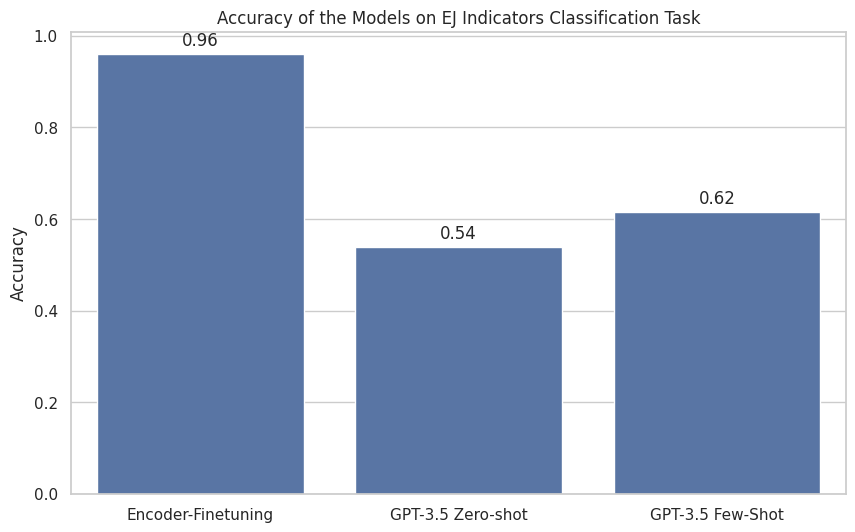

In [ ]:
# Plot Accuracies of the model

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the accuracies
# results['eval_accuracy'], average_accuracy, average_accuracy_few_shot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
accuracies = [results['eval_accuracy'], average_accuracy, average_accuracy_few_shot]
labels = ['Encoder-Finetuning', 'GPT-3.5 Zero-shot', 'GPT-3.5 Few-Shot']
sns.barplot(x=labels, y=accuracies)
plt.title('Accuracy of the Models on EJ Indicators Classification Task')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
plt.show()



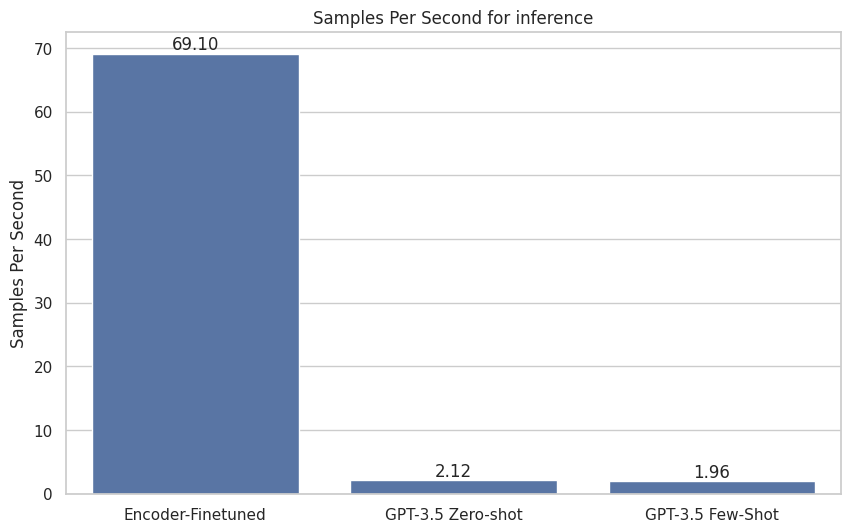

In [ ]:
# Plot Accuracies of the model

import matplotlib.pyplot as plt
import seaborn as sns

samples_per_sec = results['eval_samples_per_second']
# Plot the accuracies
# results['eval_accuracy'], average_accuracy, average_accuracy_few_shot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
time_taken_list = [samples_per_sec, len(test_data)/24, len(test_data)/26]
labels = ['Encoder-Finetuned', 'GPT-3.5 Zero-shot', 'GPT-3.5 Few-Shot']
sns.barplot(x=labels, y=time_taken_list)
plt.title('Samples Per Second for inference')
plt.ylabel('Samples Per Second')
for i, v in enumerate(time_taken_list):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom')
plt.show()

